## Method used in the code

$$p(H_0|x_{GW},x_{EM})\propto\frac{p(H0)}{\beta(H_0)}\int_{z}p(x_{GW}|z,H_0)p(x_{EM}|z)p(z)dz$$
where
- $p(x_{GW}|z,H0)$ is the GW likelihood in terms of the redshift and the Hubble constant
- $p(z)$ is the redshift prior
- $\beta{H0}$ takes into account the selection bias, i.e. for some values of H0 GW events are easier to detect
$$\beta(H_0)=\int p_{detection}(z,H_0)p(z)dz$$

In [1]:
from gwcosmo.utilities.standard_cosmology import fast_cosmology
from astropy.table import Table
from ligo.skymap.distance import marginal_pdf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ncx2, norm, truncnorm
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.integrate import quad
from astropy.cosmology import Planck15, z_at_value
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
import astropy.constants as constants
from scipy.stats import gaussian_kde
import pkg_resources
import pickle
from tqdm import tqdm
from gwpy.table import Table as gwTable
from scipy import integrate
from scipy.interpolate import splrep, splev

%matplotlib inline

In [2]:
def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[max(y), mean, sigma])
    return popt
def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
    
def dL_by_z_H0(z,H0,Om0):
    speed_of_light = constants.c.to('km/s').value
    return dl_zH0(z, H0, Om0)/(1+z) + speed_of_light*(1+z)/H0/E(z,Om0)

def E(z,Om):
    return np.sqrt(Om*(1+z)**3 + (1.0-Om))

def dLH0overc(z, Om0):
    return (1+z)*dcH0overc(z, Om0)

def dcH0overc(z, Om0):
    Omega_Lambda = (1-Om0)
    integrand = lambda zz: 1./np.sqrt(Om0*(1+zz)**3 + Omega_Lambda)
    return integrate.quad(integrand, 0, z)[0]  # in km/s

def dl_zH0(z, H0, Om0):
    c = constants.c.to('km/s').value
    z_array = np.linspace(0.0, 1.0, 5000)
    lookup = np.array([dLH0overc(z_i, Om0) for z_i in z_array])
    interp = splrep(z_array, lookup)
    return splev(z, interp, ext=3)*c/H0

def volume_time_z(z, Om0):
    return volume_z(z, Om0)/(1.0+z)

def volume_z(z, Om0):
    return dcH0overc(z, Om0)**2/h(z, Om0)

def h(z, Om0):
    Omega_Lambda = (1-Om0)
    return np.sqrt(Om0*(1+z)**3 + Omega_Lambda)

def redshift_prior(z, Om0):
    z_array = np.linspace(0.0, 1, 5000)
    lookup = np.array([volume_time_z(z_i, Om0) for z_i in z_array])
    interp = splrep(z_array, lookup)
    return splev(z, interp, ext=3)


(0.0, 1000.0)

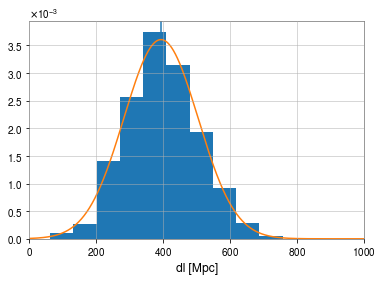

In [3]:
skymap_number = "304"

# Distance posterior
m = Table.read("fits/"+skymap_number+".fits", format="fits")
prob = m["PROBDENSITY"]
mu = m["DISTMU"]
sigma = m["DISTSIGMA"]
norm = m["DISTNORM"]


d_array = np.linspace(0, 1000, 1000)
pdf = marginal_pdf(d_array, prob, mu, sigma, norm)
A, mean_d, sigma_d = gauss_fit(d_array, pdf)
p_dist_sample = np.random.normal(mean_d, sigma_d, 1000)
table = gwTable.read("coinc_10000.xml", format="ligolw", tablename="sim_inspiral")
# d_true = table[int(skymap_number)]['distance']
d_true = mean_d

a = (0.0 - mean_d) / sigma_d # boundary so samples don't go below 0
p_dist_sample = truncnorm.rvs(a, 10000, loc=mean_d, scale=sigma_d, size=1000)

p_dist_fit = gauss(d_array, A, mean_d, sigma_d)
p_dist_fit/=np.trapz(p_dist_fit, d_array)
p_dist_fit_interp = interp1d(d_array, p_dist_fit)
plt.axvline(d_true)
plt.hist(p_dist_sample, density=True)
plt.plot(d_array, p_dist_fit, "-")
plt.xlabel("dl [Mpc]")
plt.xlim(0,1000)


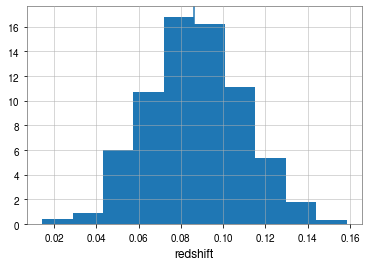

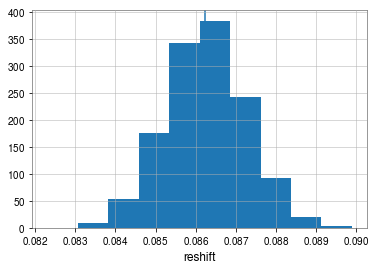

In [4]:
# redshift distribution
H0_true = 70
Om0 = 0.308
sigma_z = 1e-3
cosmo = FlatLambdaCDM(H0=H0_true, Om0=Om0)

z_true = z_at_value(cosmo.luminosity_distance, d_true*u.Mpc)
a = (0.0 - z_true) / sigma_z # boundary so samples don't go below 0
z_galaxy = truncnorm.rvs(a, 5, loc=z_true, scale=sigma_z, size=10000)
# z_galaxy = np.random.normal(z_true, sigma, 1000)

zmin = 0
zmax = 1
zs = np.linspace(zmin, zmax, 10000)
dLs = cosmo.luminosity_distance(zs).to(u.Mpc).value
z_at_dL = interp1d(dLs,zs)
redshift = z_at_dL(p_dist_sample)

plt.hist(redshift, density=True)
plt.xlabel("redshift")
plt.axvline(z_true)
plt.show()
plt.hist(z_galaxy, density=True)
plt.xlabel("reshift")
plt.axvline(z_true)
plt.show()

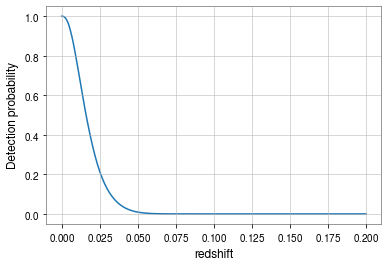

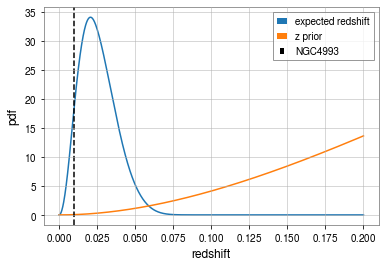

In [5]:
data_path = pkg_resources.resource_filename('gwcosmo', 'data/')
pdet = pickle.load(open(data_path+'O2PSD_BNS_Nsamps20000_full_waveform_snr_12.0.p', 'rb'))
z_array = np.linspace(0,0.2,1000) # Redshift at which you want to evaluate your det. probability

p_z = redshift_prior(z_array, Om0)
p_z/=np.trapz(p_z,z_array)

# Calculate the expected events in redshift and normalize
det_expected = p_z*pdet.pD_zH0_eval(z_array,H0_true)
det_expected /=np.trapz(det_expected,z_array)

plt.plot(z_array,pdet.pD_zH0_eval(z_array,H0_true))
plt.ylabel('Detection probability')
plt.xlabel('redshift')
plt.show()
plt.show()
plt.plot(z_array,det_expected,label='expected redshift')
plt.plot(z_array,p_z,label='z prior')
plt.axvline(0.01,label='NGC4993',ls='--',c='k')
plt.legend()
plt.xlabel('redshift')
plt.ylabel('pdf')
plt.show()


## GW likelihood
$$p(x_{GW}|z,H_0)\propto\frac{p(z|x_{GW}, H_0)}{\pi(z|H0)}\propto\frac{p(z|x_{GW}, H_0)}{|J|d_L^2(z,H_0)}$$

$$\frac{ddl}{dz}=\frac{d}{dz}\left(\frac{c(1+z)}{H_0}\int_0^z\frac{1}{\sqrt{\Omega_m(1+z')^3+(1-\Omega_m)}}dz'\right)=$$
$$=\frac{c}{H_0}\int_0^z\frac{1}{\sqrt{\Omega_m(1+z')^3+(1-\Omega_m)}}dz'+\frac{c(1+z)}{H_0}\frac{1}{\sqrt{\Omega_m(1+z)^3+(1-\Omega_m)}}$$
$$=\frac{d_L(z,H)}{1+z}+\frac{c(1+z)}{H_0}\frac{1}{\sqrt{\Omega_m(1+z)^3+(1-\Omega_m)}}$$

$$p(H_0|x_{GW},x_{EM})\propto\frac{p(H_0)}{\beta(H_0)}\int_{z}p(x_{GW}|z,H_0)p(x_{EM}|z)p(z)dz$$


In [6]:
# Define the H0 for the analysis
H0_array = np.linspace(20,200,100) 
posterior = np.ones_like(H0_array)
p_z_galaxy = redshift_prior(z_galaxy, Om0)
p_z_beta = redshift_prior(z_array, Om0)

for i,H0 in tqdm(enumerate(H0_array)):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    dLs = cosmo.luminosity_distance(zs).to(u.Mpc).value
    z_at_dL = interp1d(dLs,zs)
    redshift = z_at_dL(p_dist_sample) # p(z|x_GW, H0)

    beta = np.trapz(pdet.pD_zH0_eval(z_array,H0)*p_z_beta,z_array)
    # remove dl^2 prior from gw posterior and include dz/ddL jacobian
    weights = 1/(dL_by_z_H0(redshift,H0,Om0)*dl_zH0(redshift,H0,Om0)**2)
    norm = np.sum(weights)
    z_likelihood = gaussian_kde(redshift,weights=weights)
    posterior[i]=np.sum(z_likelihood(z_galaxy)*p_z_galaxy)*norm/beta

# Normalize
posterior/=np.trapz(posterior,H0_array)


100it [01:11,  1.41it/s]


Text(0, 0.5, 'PDF')

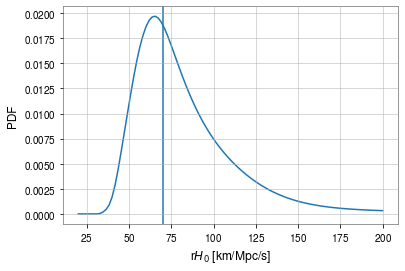

In [7]:
plt.plot(H0_array,posterior)
plt.xlabel('r$H_0$ [km/Mpc/s]')
plt.axvline(70)
plt.ylabel('PDF')
